# Web Scraping Covid Reports from WHO (World Health Organization)

<p>Matheus Schmitz</p></p>
<p><a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a></p>
<p><a href="https://matheus-schmitz.github.io/">Github Portfolio</a></p>

## Problem Statement

Since January / 2020, WHO (World Health Organization) has been issuing daily newsletters on the contamination and deaths caused by COVID-19. These bulletins are published in reports in pdf format with tables showing the numbers by country and the total by continent.

With the data in hand, I will do a quick exploration and build some graphs showing the trend line through polynomial equation.

After that, I will use the data to fit a mathematical model of forecasting the contamination curve, working with nonlinear least squares.

## Data Source

The official World Health Organization webpage: https://www.who.int

# Packages

In [97]:
# Imports
import io
import bs4
import requests
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
from tqdm import tqdm

# Para processar arquivos PDF
from PyPDF2 import PdfFileReader

# Funções para o modelo matemático
import scipy
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

## Web Scraping

In [4]:
# Base URL
base_url = 'https://www.who.int'

# URL containing COVID-19 data
url = 'https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/'

In [6]:
# Get the data from the URL
response = requests.get(url)

# Then parse the data with BeautifulSoup
soup = BeautifulSoup(response.content, 'lxml')

In [51]:
# List to store links to the "situation-reports"
links_list = []

# Loop through the page elements to fing the "a" tags, which indicate URLs
for element in soup.find_all('a', href=True):
    # Seaching for urls directing to "situation-reports"
    if 'situation-reports' in str(element):
        links_list.append(str(element))

print(f'Found {len(links_list)} situation-repots.')

Found 208 situation-repots.


In [52]:
# View some of the results
links_list[:3]

['<a href="/docs/default-source/coronaviruse/situation-reports/20200815-covid-19-sitrep-208.pdf?sfvrsn=9dc4e959_2" target="_blank"></a>',
 '<a href="/docs/default-source/coronaviruse/situation-reports/20200816-covid-19-sitrep-209.pdf?sfvrsn=5dde1ca2_2" target="_blank"><strong>Situation report - 209</strong></a>',
 '<a href="/docs/default-source/coronaviruse/situation-reports/20200815-covid-19-sitrep-208.pdf?sfvrsn=9dc4e959_2" target="_blank"><strong>Situation report - 208</strong></a>']

In [166]:
# Set to store the URLs of the PDF files (using set to avoid duplicates)
pdf_urls = list()

# Variable to store the number of the last report read
# (Some reports are published twice and we don't want to read them duplicate)
last_report = None

# Loop through each of the urls extracted and obtain the URL to the PDF
# Start from the oldest report ([::-1])
for url in links_list[::-1]:
    
    # Replace the html link tag
    x = url.replace('<a href="', '')
    
    # Find the question mark to use an index of the last character of the PDF URL
    index = x.find('?')
    
    # Extract the PDF URL
    extraction = x[0:index]
    
    # Then add the PDF URL path to the pdf_urls list
    pdf_urls.append(base_url + extraction)

In [169]:
# Remove duplicates
pdf_urls = list(dict.fromkeys(pdf_urls))
print(f'Removed {len(links_list) - len(pdf_urls)} duplicates')

# View some of the results
pdf_urls[-3:]

Removed 2 duplicates


['https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200814-covid-19-sitrep-207.pdf',
 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200815-covid-19-sitrep-208.pdf',
 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200816-covid-19-sitrep-209.pdf']

> Great! Now let me first extract the data from one of the files to make sure everything works fine, and then I can go through all files.

In [170]:
# Get a sample file
sample = pdf_urls[10]

# Request the file to the HTML page
request = requests.get(sample)

# Response code [200] means it worked!
request

<Response [200]>

In [171]:
# Save the file to a format which can be read
file = io.BytesIO(request.content)

# And then use a PDF reader to read the file
file_pdf = PdfFileReader(file)
type(file_pdf)

PyPDF2.pdf.PdfFileReader

In [284]:
# Extract the text in the PDF and split the lines
content = file_pdf.getPage(4).extractText().split('\n')

In [285]:
# Check if we can get data by country
try:
    print(content.index('South Africa'))
except:
    pass

> Great, country indexing works! Let's now iterate through all PDFs and get the data.

In [175]:
# Lists to store the findings
total_confirmed = []
total_confirmed_new = []
total_deceased = []
total_deceased_new = []

In [186]:
%%time

country = 'South Korea'

# Loop through the PDFs
for pdfurl in tqdm(pdf_urls):
    
    # Get the file
    request = requests.get(pdfurl)
    
    # Save the file to a format which can be read
    file = io.BytesIO(request.content)

    # And then use a PDF reader to read the file
    file_pdf = PdfFileReader(file)
    
    # Loop through the pages in the pdf
    for page in range(file_pdf.getNumPages()):
        try:
            
            # Extract the text
            content = file_pdf.getPage(page).extractText().split('\n')
            
            # Find country index
            country_index = (content.index(country))
            
            # Store the result in the lists
            total_confirmed.append(content[country_index + 2])
            total_confirmed_new.append(content[country_index + 4])
            total_deceased.append(content[country_index + 6])
            total_deceased_new.append(content[country_index + 8])
        
        except:
            pass

100%|████████████████████████████████████████| 206/206 [06:57<00:00,  2.03s/it]

Wall time: 6min 57s


In [224]:
# Create a dataframe from the lists
df_covid = pd.DataFrame(data = [total_confirmed,
                                total_confirmed_new,
                                total_deceased,
                                total_deceased_new]).transpose()
df_covid.columns = ['total_confirmed', 'total_confirmed_new', 'total_deceased', 'total_deceased_new']
print(f'df_covid.shape: {df_covid.shape}')

df_covid.shape: (160, 4)


In [225]:
# Visualize
df_covid.head()

,total_confirmed,total_confirmed_new,total_deceased,total_deceased_new
0,2,2,0,0
1,2,0,0,0
2,7,5,0,0
3,9,0,0,0
4,13,4,0,0


In [226]:
# Visualize
df_covid.tail()

,total_confirmed,total_confirmed_new,total_deceased,total_deceased_new
155,,,157,
156,,,120,
157,,,278,
158,,,325,
159,53,981,198,1


In [227]:
# Seems like the last row has only partial data... remove it
df_covid.drop(df_covid.tail(1).index, inplace=True)

> Unfortunately seems like not all days have all data points.

## Exploratory Analysis

> First some data cleaning is in order.

In [230]:
# Swap spaces for zeros
df_plot = df_covid.replace(' ', np.NaN)
df_plot = df_plot.dropna()
df_plot['total_confirmed'] = df_plot['total_confirmed'].str.replace(' ', '')
df_plot['total_confirmed_new'] = df_plot['total_confirmed_new'].str.replace(' ', '')
df_plot['total_deceased'] = df_plot['total_deceased'].str.replace(' ', '')
df_plot['total_deceased_new'] = df_plot['total_deceased_new'].str.replace(' ', '')

# convert data to int type
df_plot = df_plot.astype(int)
print(f'df_plot.shape: {df_plot.shape}')
df_plot.tail(10)

df_plot.shape: (89, 4)


,total_confirmed,total_confirmed_new,total_deceased,total_deceased_new
97,34885,392,1485,6
102,36463,283,1512,7
107,38464,375,1527,3
110,39392,259,1534,4
121,43569,413,1,605
123,44,129,232,1
132,47426,375,1676,8
136,48636,246,1689,5
140,49692,313,1712,7
154,52668,131,1756,6


> Creating some plots and adding a trend line using np.polyfit() and np.poly1d() for polinomial.fitting.

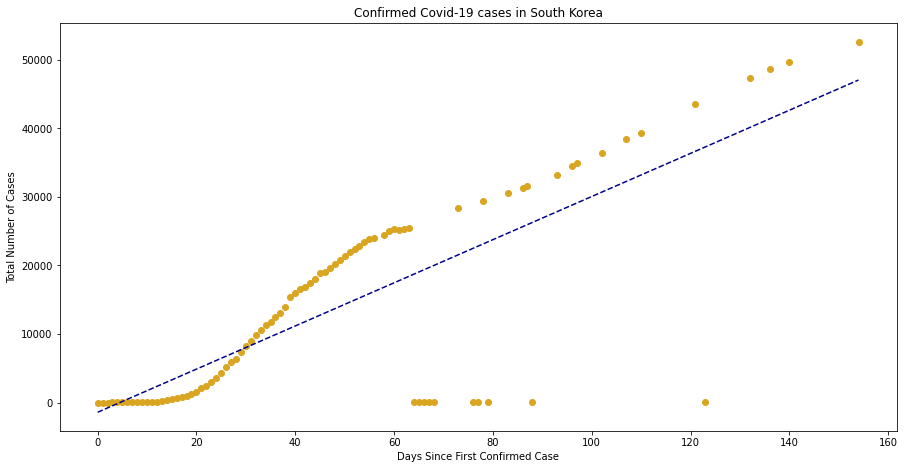

In [233]:
# Plot 1
fix, ax = plt.subplots(figsize=(16,9)))

# Plot data
x = df_plot.index
y = df_plot['total_confirmed']
plt.scatter(x, y, color='goldenrod')

# Trendline with np.polyfit
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", color='darkblue')

# Title and labels
plt.title(f'Confirmed Covid-19 Cases in {country}')
plt.xlabel('Days Since First Confirmed Case')
plt.ylabel('Total Number of Cases')
plt.show()

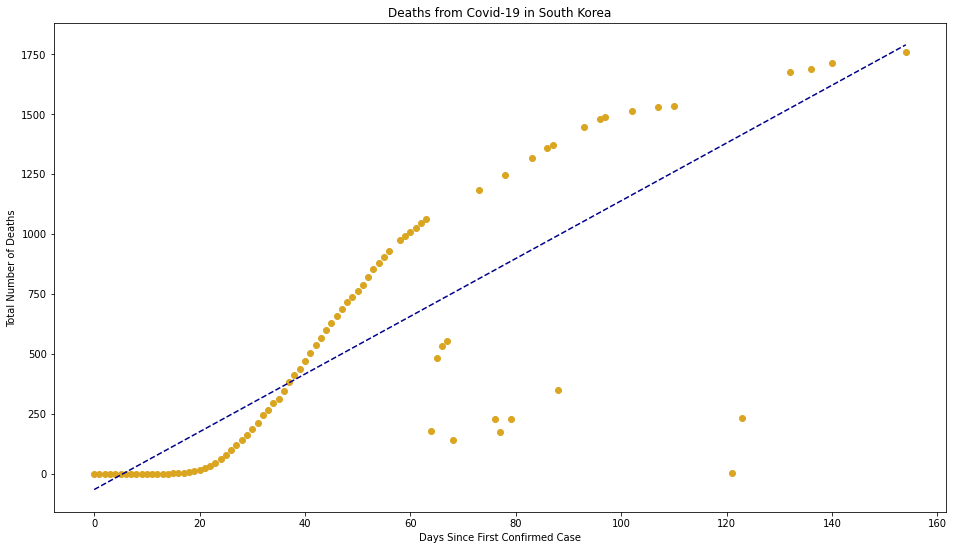

In [246]:
# Plot 2
fix, ax = plt.subplots(figsize=(16,9))

# Plot data
x = df_plot.index
y = df_plot['total_deceased']
plt.scatter(x, y, color='goldenrod')

# Trendline with np.polyfit
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", color='darkblue')

# Title and labels
plt.title(f'Deaths from Covid-19 in {country}')
plt.xlabel('Days Since First Confirmed Case')
plt.ylabel('Total Number of Deaths')
plt.show()

## Predictive Modeling

> Using a logistic model to build a growth curve, then a mathematical model to predict the curve.

In [273]:
# Creating a logistic model
# x = inputs
# a = growth rate
# b = peak of x
# L = max y value
def logistic_model(x, a, b, L):
    return L / (1 + np.exp(-(x - b) / a))

In [274]:
x = df_plot.index
y = df_plot['total_confirmed']

In [275]:
# Fit the logistic model curve
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
covid_model = curve_fit(logistic_model, x, y, p0 = [2, 100, 20000])

In [276]:
# Extract from the model the values of interest
growth_rate, peak_x, max_y = covid_model[0]

In [277]:
# Calculate the errors
growth_rate_error, peak_x_error, max_y_error = [np.sqrt(covid_model[1][i][i]) for i in [0, 1, 2]]

In [278]:
# Now solve the non-linear equation with fsolve()
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
result = int(fsolve(lambda x: logistic_model(x, growth_rate, peak_x, max_y) - max_y * 0.9999, peak_x))

In [279]:
# x range
x_range = list(range(min(x), result))

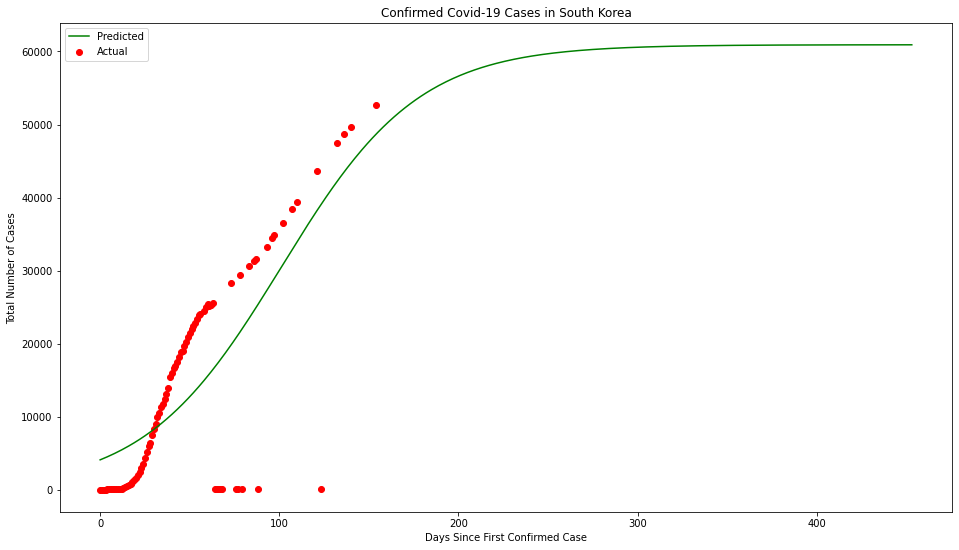

In [280]:
# Plot predictions
fix, ax = plt.subplots(figsize=(16,9))

# Plot data
plt.plot(x_range, [logistic_model(i, growth_rate, peak_x, max_y) for i in x_range], color = 'green')
plt.scatter(x, y, color = 'red')

# Title and labels
plt.title(f'Confirmed Covid-19 Cases in {country}')
plt.xlabel('Days Since First Confirmed Case')
plt.ylabel('Total Number of Cases')
plt.legend(['Predicted', 'Actual'])
plt.show()

> Seems like modeling the covid pandemic with a logistic regression did a semi-good job at best...

<p><h1 id="End">End<a class="anchor-link" href="#End">&#182;</a></h1>
<p>Matheus Schmitz</p></p>
<p><a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a></p>
<p><a href="https://matheus-schmitz.github.io/">Github Portfolio</a></p>